In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pandas_datareader import data as pdr
import yfinance as yf

In [2]:
# Definire l'intervallo di date
start_date = '2010-01-01'
end_date = '2023-10-31'

# Scaricare i dati
sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1d')[['Adj Close']]


sp500.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close
Ticker,^GSPC
Date,
2010-01-04 00:00:00+00:00,1132.989990
2010-01-05 00:00:00+00:00,1136.520020
2010-01-06 00:00:00+00:00,1137.140015
2010-01-07 00:00:00+00:00,1141.689941
2010-01-08 00:00:00+00:00,1144.979980


In [3]:
# Controllo dei valori mancanti
sp500.isnull().sum()

"""
def sanity_check(sp500):
    if sp500.isnull().values.any():
        data.fillna(method='ffill', inplace=True)
        print("Missing values have been forward-filled")
    else:
        print("No missing values in the data.")
    
    return sp500
"""
# sp500 = sanity_check(sp500)

'\ndef sanity_check(sp500):\n    if sp500.isnull().values.any():\n        data.fillna(method=\'ffill\', inplace=True)\n        print("Missing values have been forward-filled")\n    else:\n        print("No missing values in the data.")\n    \n    return sp500\n'

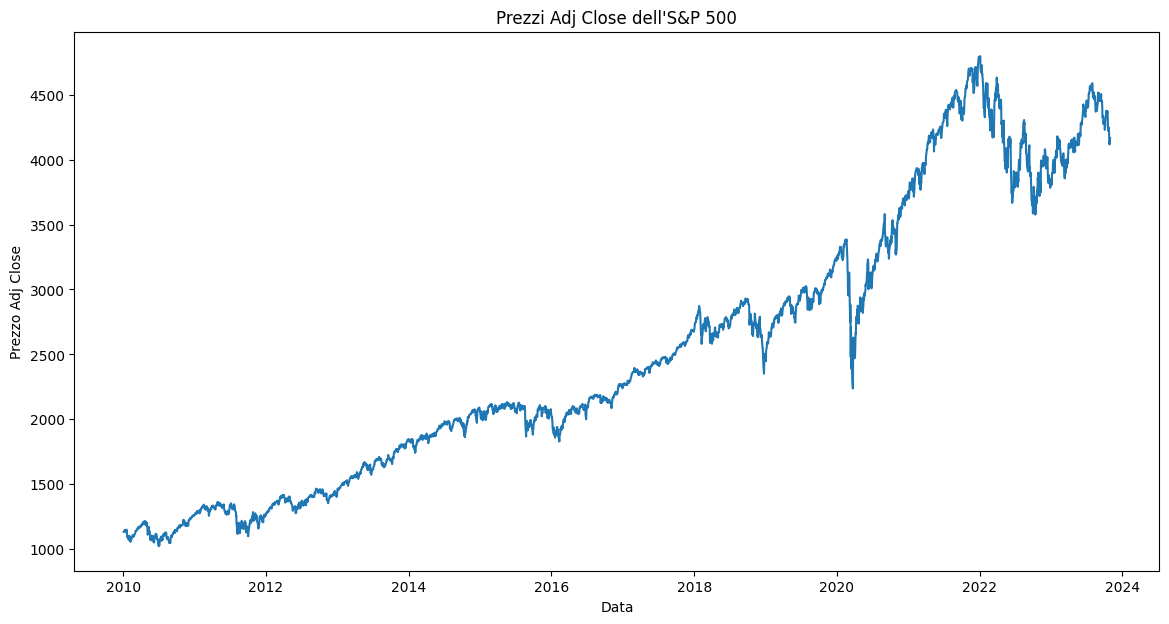

In [4]:
# Analisi esplorativa dati EDA

plt.figure(figsize=(14,7))
plt.plot(sp500['Adj Close'])
plt.title('Prezzi Adj Close dell\'S&P 500')
plt.xlabel('Data')
plt.ylabel('Prezzo Adj Close')
plt.show()


In [5]:
sp500['Adj Close'].describe()

Ticker,^GSPC
count,3480.000000
mean,2510.643100
std,1053.289223
min,1022.580017
25%,1639.587524
50%,2203.799927
75%,3221.237488
max,4796.560059


# Test di Augmented Dickey-Fuller (ADF)

Il test ADF è utilizzato per determinare se una serie temporale è **stazionaria** o **non stazionaria**. In particolare, verifica la presenza di una **radice unitaria** nella serie.

**Ipotesi del test:**

- **Ipotesi Nulla (H₀)**: La serie ha una radice unitaria (la serie è **non stazionaria**).
- **Ipotesi Alternativa (H₁)**: La serie non ha una radice unitaria (la serie è **stazionaria**).

La statistica ADF calcolata è **-0.38**. I valori critici rappresentano le soglie oltre le quali possiamo rifiutare l'ipotesi nulla a diversi livelli di significatività (1%, 5%, 10%).

---

**Cosa significa che la statistica ADF è maggiore dei valori critici?**

Maggiore in questo contesto significa **meno negativa**. Poiché le soglie dei valori critici sono numeri negativi, una statistica ADF meno negativa (più vicina a zero) indica meno evidenza contro l'ipotesi nulla.

---

**Conclusione:**

- La statistica ADF **non è sufficientemente negativa** per superare nessuna delle soglie dei valori critici.
- Pertanto, **non possiamo rifiutare l'ipotesi nulla** di presenza di radice unitaria (non stazionarietà) a nessuno dei livelli di significatività standard.


In [6]:
# Test ADF per la stazionarietà
def adf_test(series):
    # Drop NaN or inf values
    series_clean = series.dropna()
    result = adfuller(series_clean)
    print("Statistic ADF: %.2f" % result[0])
    print("P-Value: %.3f" % result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


adf_test(sp500['Adj Close'])

Statistic ADF: -0.38
P-Value: 0.913
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [7]:
adf_test(sp500['Adj Close'].diff().dropna())

Statistic ADF: -12.20
P-Value: 0.000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [8]:
adf_test(np.log(sp500['Adj Close'] / sp500['Adj Close'].shift(1)))

Statistic ADF: -12.87
P-Value: 0.000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Dobbiamo avere una serie stazionaria
stat_data = sp500['Adj Close'].diff().dropna()

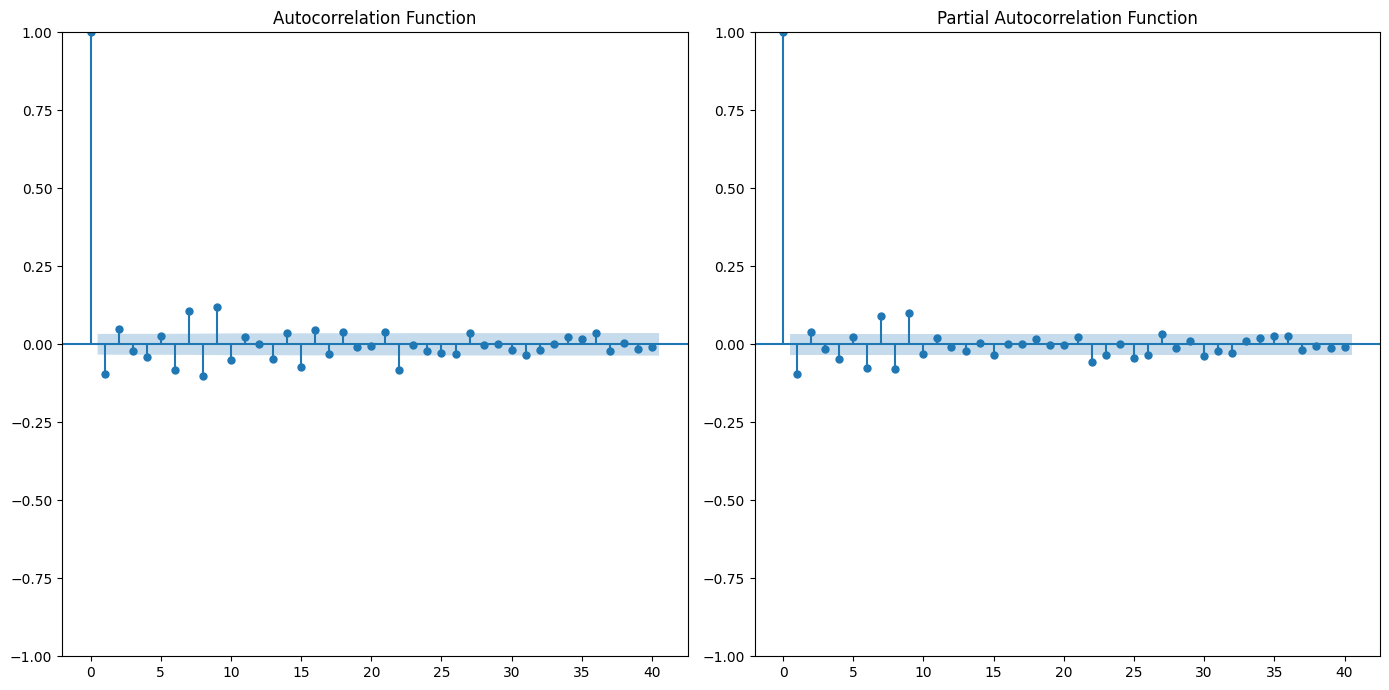

In [12]:
# Plotting ACF
plt.figure(figsize=(14, 7))
plt.subplot(121) # 1 riga, 2 colonne, 1st subplot
plot_acf(stat_data, ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function')


# Plottinf PACF
plt.subplot(122) # 1 riga, 2 colonne, 2nd subplot
plot_pacf(stat_data, ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [10]:
train_size = int(len(sp500) * 0.8)
train_data = sp500['Adj Close'][:train_size]
test_data = sp500['Adj Close'][train_size:]

In [11]:
import warnings
warnings.filterwarnings('ignore')  # Ignora gli avvisi per modelli non convergenti

import itertools

# Definisci gli intervalli per p, d, q
p = range(0, 4)
d = range(0, 2)
q = range(0, 4)

# Genera tutte le combinazioni possibili
pdq = list(itertools.product(p, d, q))

# Lista per memorizzare i risultati
results = []

for param in pdq:
    try:
        model = ARIMA(train_data, order=param)
        model_fit = model.fit()
        aic = model_fit.aic
        results.append((param, aic))
        print(f'ARIMA{param} - AIC:{aic}')
    except:
        continue


# Trova la combinazione con l'AIC più basso
best_model = min(results, key=lambda x: x[1])
print(f'\nMiglior modello: ARIMA{best_model[0]} - AIC:{best_model[1]}')

ARIMA(0, 0, 0) - AIC:44256.33137072255
ARIMA(0, 0, 1) - AIC:40874.51346616479
ARIMA(0, 0, 2) - AIC:41938.576337672974
ARIMA(0, 0, 3) - AIC:37116.65015040936
ARIMA(0, 1, 0) - AIC:25774.46091960823
ARIMA(0, 1, 1) - AIC:25703.939718692236
ARIMA(0, 1, 2) - AIC:25646.310071951724
ARIMA(0, 1, 3) - AIC:25646.57875773353
ARIMA(1, 0, 0) - AIC:25795.383076341554
ARIMA(1, 0, 1) - AIC:25724.99126471711
ARIMA(1, 0, 2) - AIC:25667.25217143848
ARIMA(1, 0, 3) - AIC:25667.547670763233
ARIMA(1, 1, 0) - AIC:25685.71135397458
ARIMA(1, 1, 1) - AIC:25669.120663018635
ARIMA(1, 1, 2) - AIC:25647.24804600788
ARIMA(1, 1, 3) - AIC:25644.81528411407
ARIMA(2, 0, 0) - AIC:25706.774355932077
ARIMA(2, 0, 1) - AIC:25783.479854170288
ARIMA(2, 0, 2) - AIC:25699.325243826246
ARIMA(2, 0, 3) - AIC:25616.130524769607
ARIMA(2, 1, 0) - AIC:25653.60895692998
ARIMA(2, 1, 1) - AIC:25654.185312883335
ARIMA(2, 1, 2) - AIC:25646.581606502135
ARIMA(2, 1, 3) - AIC:25642.083029243477
ARIMA(3, 0, 0) - AIC:25674.591576112332
ARIMA(3, 0,